In [1]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from astropy.io import fits
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle
from importlib import reload

import warnings
warnings.filterwarnings("ignore")

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import cgi_phasec_poppy
from cgi_phasec_poppy.imshows import *
from cgi_phasec_poppy.math_module import xp
reload(cgi_phasec_poppy)
data_dir = cgi_phasec_poppy.data_dir

import misc_funs as misc

dm1_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm1.fits')
dm2_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm2.fits')

iwa = 6
owa = 20

wavelength_c = 825e-9*u.m

nwaves = 7
bandwidth = 10/100
minwave = wavelength_c * (1 - bandwidth/2)
maxwave = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minwave, maxwave, nwaves )


In [2]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

kwargs = {
    'cgi_mode':'spc-wide',
    'npsf':150,
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':0,
}

actors = []
for i in range(nwaves):
    actors.append(rayCGI.options(num_cpus=2, num_gpus=1/8).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])

2024-01-02 14:47:27,870	INFO worker.py:1636 -- Started a local Ray instance.


# Without noise

In [7]:
mode.Imax_ref

(CGI pid=3717264) After resampling, optic phasor shape (1045, 1045) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array.
(CGI pid=3717257) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
(CGI pid=3717257)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')


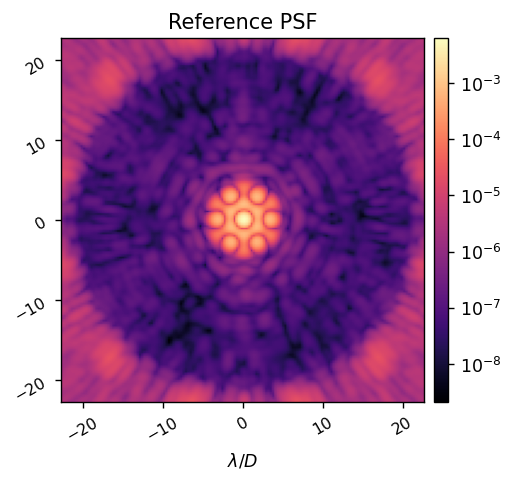

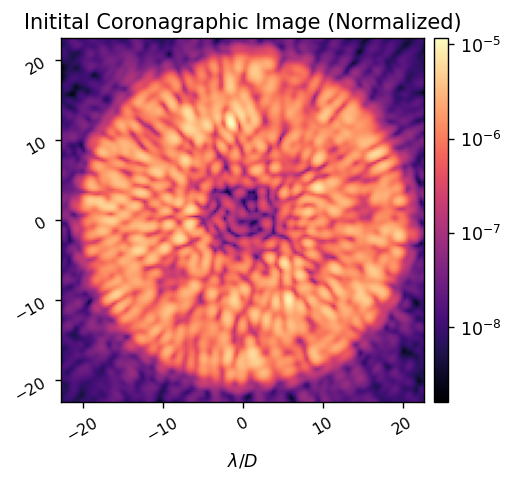

In [3]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)

mode.set_dm1(dm1_flat)
mode.set_dm2(dm2_flat)

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, 'Reference PSF',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', symlognorm=True, )

max_ref = xp.max(ref_unocc_im)
mode.Imax_ref = max_ref

mode.set_actor_attr('use_fpm',True)

ref_im = mode.snap()
imshow1(ref_im, 'Initital Coronagraphic Image (Normalized)', 
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', symlognorm=True,)


# With noise

1.3624486320346218e-17 sr
	Flux for wavelength 7.838e-07 m: 5.094e+08 ph / (s m2)
	Flux for wavelength 7.975e-07 m: 4.856e+08 ph / (s m2)
	Flux for wavelength 8.113e-07 m: 4.632e+08 ph / (s m2)
	Flux for wavelength 8.250e-07 m: 4.422e+08 ph / (s m2)
	Flux for wavelength 8.388e-07 m: 4.224e+08 ph / (s m2)
	Flux for wavelength 8.525e-07 m: 4.038e+08 ph / (s m2)
	Flux for wavelength 8.663e-07 m: 3.862e+08 ph / (s m2)
Total flux: 3.113e+09 ph / (s m2)


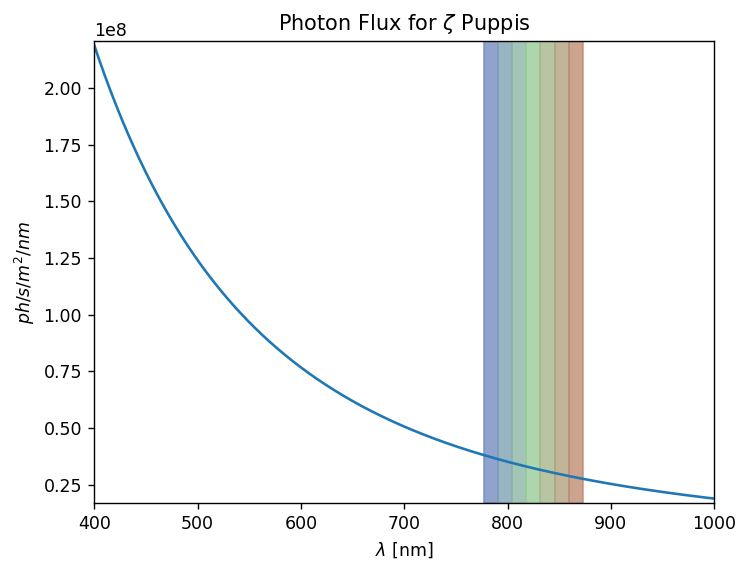

In [4]:
reload(cgi_phasec_poppy.source_flux)

minlam = 400*u.nm
maxlam = 1000*u.nm
nlam = int((maxlam-minlam).value*20) + 1
lambdas = np.linspace(minlam, maxlam, nlam)

from astropy.constants import h, c, k_B, R_sun

zpup = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=40000*u.K,
                                            distance=300*u.parsec,
                                            diameter=2*14*R_sun,
                                            name='$\zeta$ Puppis', 
                                            lambdas=lambdas,
                                           )

zpup.plot_spectrum_ph()
source_fluxes = zpup.calc_fluxes()
total_flux = np.sum(source_fluxes)

for i,flux in enumerate(source_fluxes):
    print(f'\tFlux for wavelength {wavelengths[i]:.3e}: {flux:.3e}')
    actors[i].setattr.remote('source_flux', source_fluxes[i])
print(f'Total flux: {total_flux:.3e}')

In [10]:
reload(cgi_phasec_poppy.imshows)
from cgi_phasec_poppy.imshows import *

(CGI pid=523567) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array. [repeated 127x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(CGI pid=523569) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1 [repeated 27x across cluster]
(CGI pid=523569)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1') [repeated 27x across cluster]


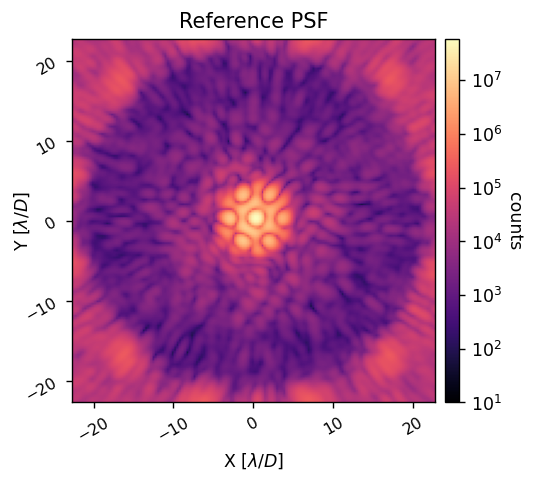

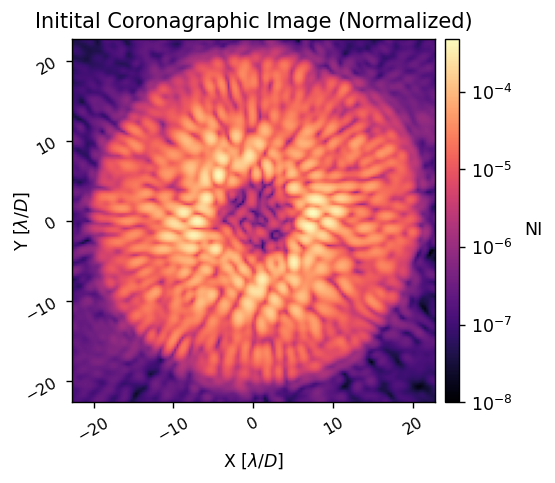

In [6]:


mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)

mode.use_noise = True
mode.exp_time = 2*u.s
mode.gain = 1
mode.dark_current_rate = 0.05*u.electron/u.pix/u.hour
mode.read_noise = 120*u.electron/u.pix

mode.set_actor_attr('use_fpm',False)
ref_unocc_im = mode.snap()
fig,ax = imshow1(ref_unocc_im, 'Reference PSF',
        cbar_label='counts', clabel_rot=270,
        pxscl=mode.psf_pixelscale_lamD, xlabel='X [$\lambda/D$]', symlognorm=True, vmin=1e1, 
        display_fig=False, return_fig=True)
ax.set_ylabel('Y [$\lambda/D$]', labelpad=-5)
# fig.savefig('bb_unocc.pdf', format='pdf', bbox_inches="tight")
display(fig)


mode.set_actor_attr('use_fpm',True)
max_ref = xp.max(ref_unocc_im)
mode.Imax_ref = max_ref

mode.exp_time_ref = mode.exp_time
mode.gain_ref = mode.gain

mode.exp_time = 1/2*u.s
mode.gain = 1

ref_im = mode.snap()
fig,ax = imshow1(ref_im, 'Initital Coronagraphic Image (Normalized)', 
        cbar_label='NI', 
        pxscl=mode.psf_pixelscale_lamD, xlabel='X [$\lambda/D$]', symlognorm=True, vmin=1e-8,
                display_fig=False, return_fig=True)
# fig,ax = imshow1(ref_im, 'Coronagraphic Image',
#         cbar_label='counts', clabel_rot=270,
#         pxscl=mode.psf_pixelscale_lamD, xlabel='X [$\lambda/D$]', symlognorm=True, vmin=1e0, 
#         display_fig=False, return_fig=True)
ax.set_ylabel('Y [$\lambda/D$]', labelpad=-5)
# fig.savefig('bb_image.pdf', format='pdf', bbox_inches="tight")
display(fig)


# Only using photon noise

(CGI pid=3267996) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array. [repeated 63x across cluster]
(CGI pid=3267995) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1 [repeated 14x across cluster]
(CGI pid=3267995)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1') [repeated 14x across cluster]


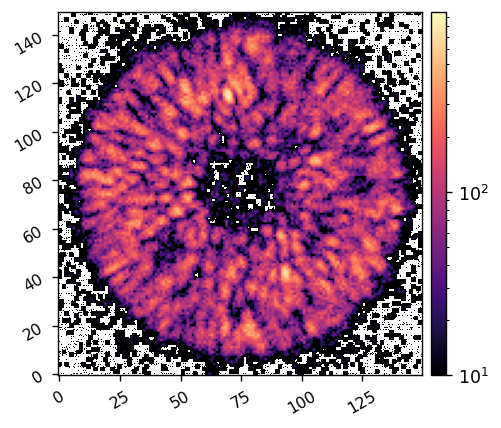

In [8]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors)
mode.set_dm1(dm1_flat)
mode.set_dm2(dm2_flat)

mode.use_photon_noise = True
mode.exp_time = 0.1

im = mode.snap()

imshow1(im, lognorm=True)


# Now using the EMCCD with photon noise
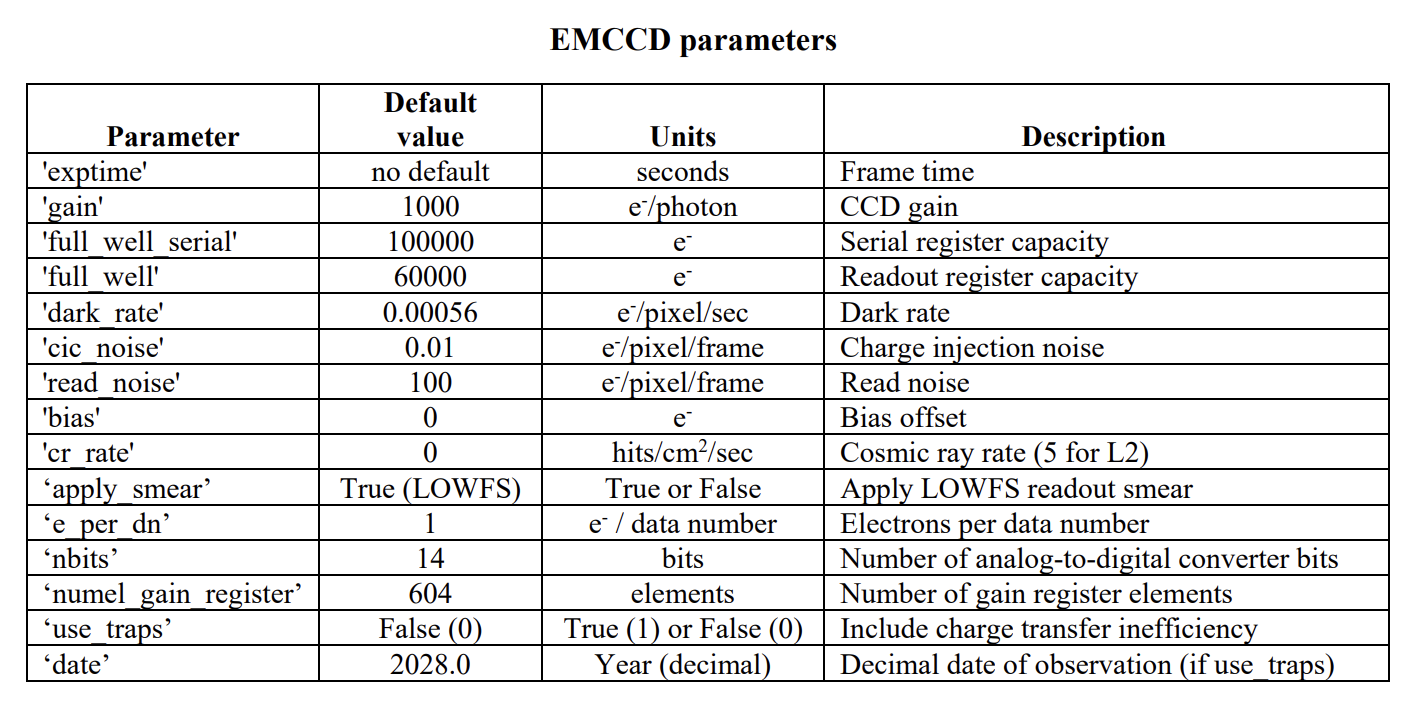

(CGI pid=3717264) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array. [repeated 126x across cluster]
(CGI pid=3717257) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1 [repeated 28x across cluster]
(CGI pid=3717257)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1') [repeated 28x across cluster]


Adding photon noise for frame 1.
Simulating EMCCD frame 1.
Adding photon noise for frame 2.
Simulating EMCCD frame 2.
Adding photon noise for frame 3.
Simulating EMCCD frame 3.
Adding photon noise for frame 4.
Simulating EMCCD frame 4.
Adding photon noise for frame 5.
Simulating EMCCD frame 5.


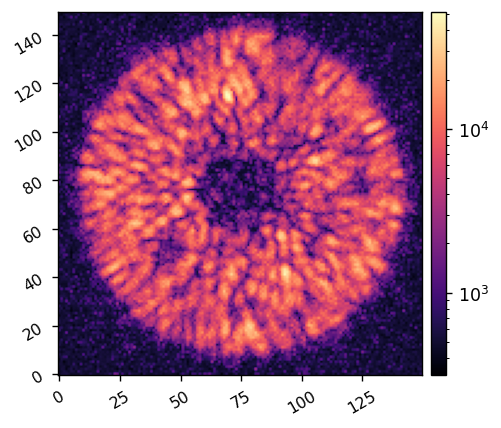

In [22]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors, dm1_ref=dm1_flat, dm2_ref=dm2_flat)

from emccd_detect import emccd_detect
meta_path = Path('/home/kianmilani/Projects/emccd_detect/emccd_detect/emccd_detect/util/metadata.yaml')

em_gain = 250
full_well_image=60000.  # e-
full_well_serial=100000.  # e-
#status=1,
dark_current=8e-4  # e-/pix/s
cic=0.01  # e-/pix/frame
read_noise=120.  # e-/pix/frame
bias=500.  # e-
qe=0.5
cr_rate=0.  # hits/cm^2/s
pixel_pitch=13e-6  # m
eperdn=1 #7.,
nbits=16#14,
numel_gain_register=604

emccd = emccd_detect.EMCCDDetect(em_gain=em_gain,
                                    full_well_image=full_well_image,  # e-
                                    full_well_serial=full_well_serial,  # e-
                                    #status=status,
                                    dark_current=dark_current,  # e-/pix/s
                                    cic=cic,  # e-/pix/frame
                                    read_noise=read_noise,  # e-/pix/frame
                                    bias=bias,  # e-
                                    qe=qe,
                                    cr_rate=cr_rate,  # hits/cm^2/s
                                    pixel_pitch=pixel_pitch,  # m
                                    eperdn=eperdn,
                                    nbits=nbits,
                                    numel_gain_register=numel_gain_register,
                                    meta_path=meta_path
                                    )

mode.use_photon_noise = True
mode.EMCCD = emccd

mode.Nframes = 5
mode.exp_time = 0.5
im = mode.snap(quiet=False)
imshow1(im, lognorm=True)

(CGI pid=3717264) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array. [repeated 21x across cluster]
(CGI pid=3717257) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1 [repeated 14x across cluster]
(CGI pid=3717257)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1') [repeated 14x across cluster]
(CGI pid=3717264) After resampling, optic phasor shape (1504, 1504) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array. [repeated 168x across cluster]
(CGI pid=3717257) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1 [repeated 28x across cluster]
(CGI pid=3717257)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when 

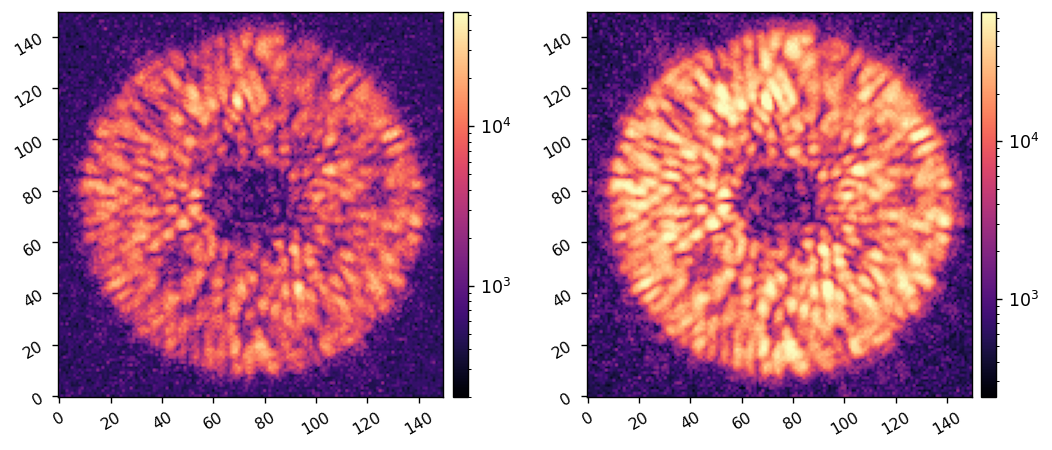

In [84]:
exp_times = [0.5, 1.5, 5]
ims = []
darks = []
im_masks = []
mode.Nframes = 2
for i in range(len(exp_times)):
    mode.exp_time = exp_times[i]
    # darks.append(mode.snap_dark())
    im = mode.snap()
    ims.append(im)
    im_masks.append((im>2**mode.EMCCD.nbits -100))
imshow2(ims[0], ims[1], lognorm=True)

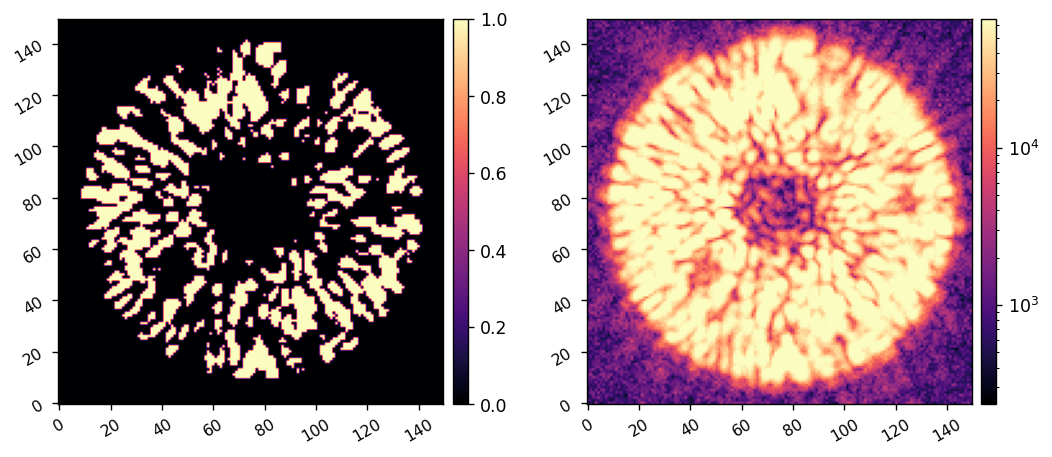

In [85]:
imshow2(im_masks[2], ims[2], lognorm2=True)

In [70]:
import copy

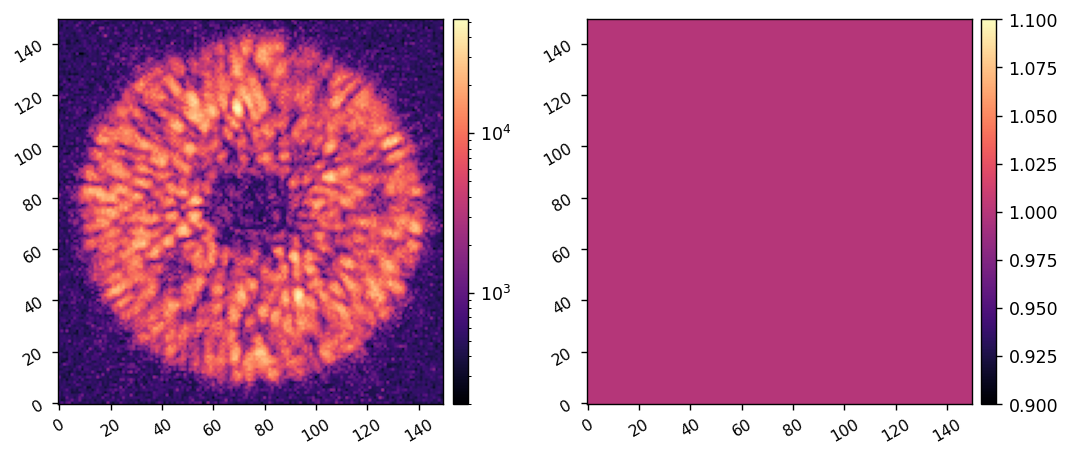

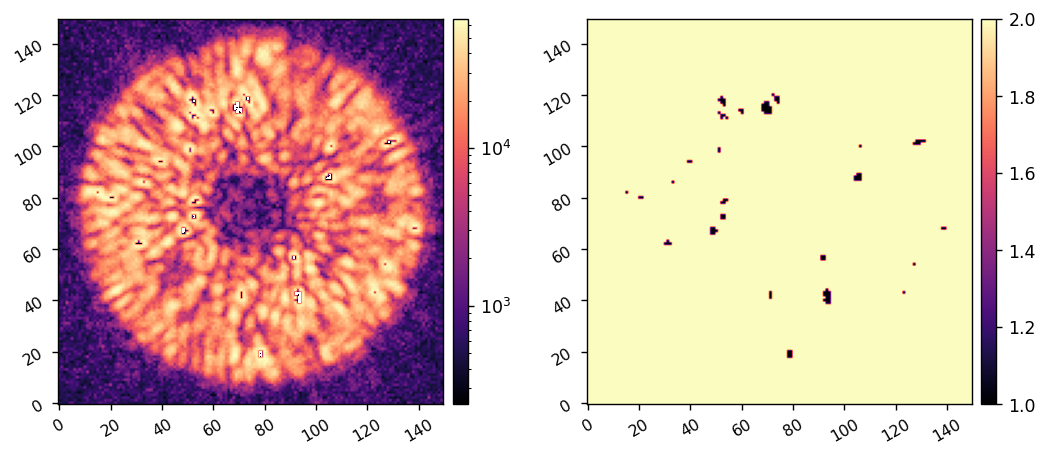

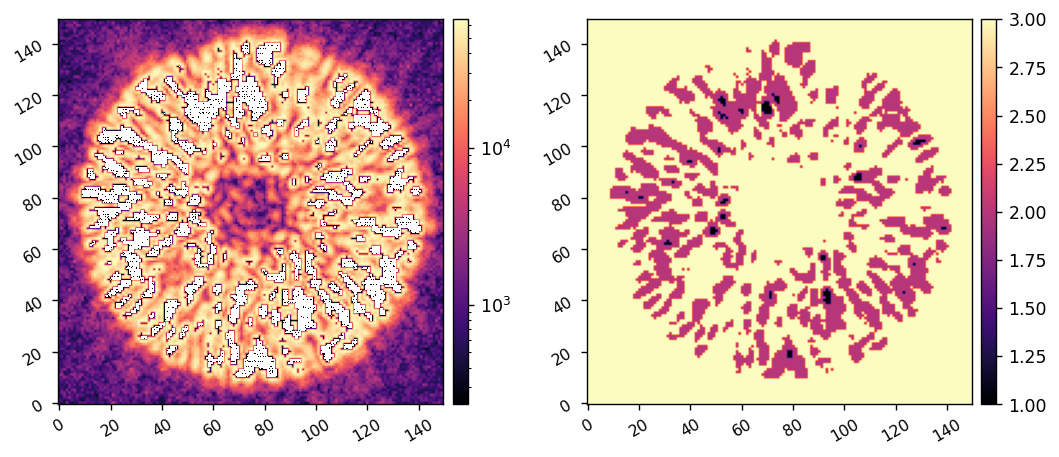

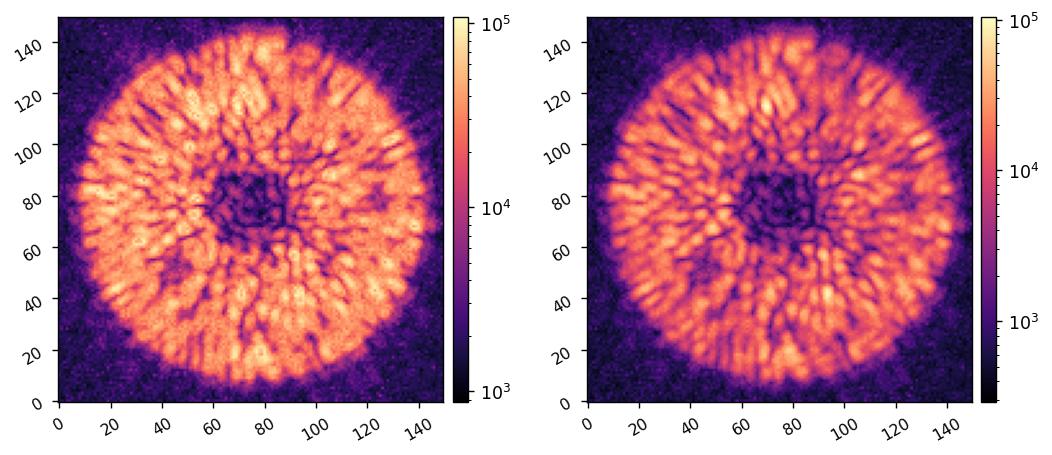

In [86]:
total_flux = 0.0
pixel_weights = 0.0
for i in range(len(exp_times)):
    flux_im = copy.copy(ims[i])
    flux_im[im_masks[i]] = 0
    pixel_weights += ~im_masks[i]
    imshow2(flux_im, pixel_weights, lognorm1=True)
    flux_im /= exp_times[i]
    total_flux += flux_im
total_im = total_flux/pixel_weights
imshow2(total_flux, total_im, lognorm=True)

In [13]:
im.max()

array(59871.)

In [38]:
emccd.nbits

14

# Normalizing to get normalized intensity images with noise.

(CGI pid=3267996) After resampling, optic phasor shape (1045, 1045) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array. [repeated 62x across cluster]
(CGI pid=3267995) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1 [repeated 14x across cluster]
(CGI pid=3267995)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1') [repeated 14x across cluster]


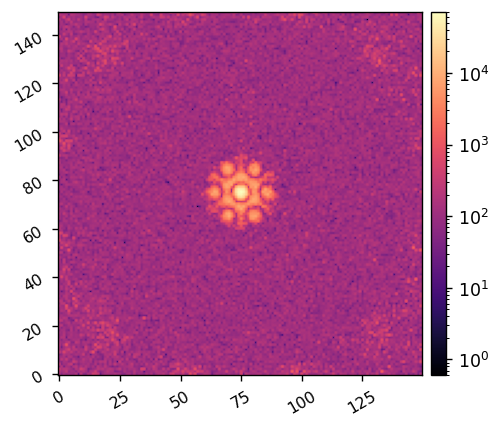

Generating photon noise for frame 1.
Generating photon noise for frame 2.
Generating photon noise for frame 3.
Generating photon noise for frame 4.
Generating photon noise for frame 5.


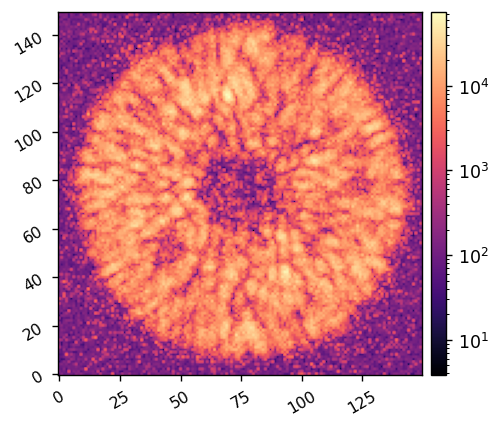

(CGI pid=3267996) After resampling, optic phasor shape (1305, 1305) is smaller than input wavefront (2048, 2048); will zero-pad the rescaled array. [repeated 127x across cluster]
(CGI pid=3267995) /home/kianmilani/Projects/poppy/poppy/geometry.py:207: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1 [repeated 28x across cluster]
(CGI pid=3267995)   warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1') [repeated 28x across cluster]


Generating photon noise for frame 1.
Generating photon noise for frame 2.
Generating photon noise for frame 3.
Generating photon noise for frame 4.
Generating photon noise for frame 5.
Normalizing to max value


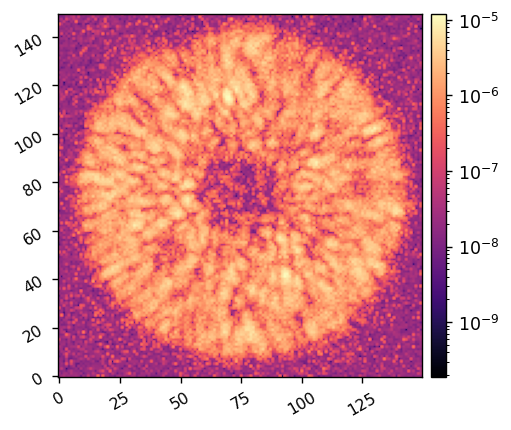

In [33]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors, dm1_ref=dm1_flat, dm2_ref=dm2_flat)

from emccd_detect import emccd_detect
meta_path = Path('/home/kianmilani/Projects/emccd_detect/emccd_detect/emccd_detect/util/metadata.yaml')

em_gain = 200
full_well_image=60000.  # e-
full_well_serial=100000.  # e-
#status=1,
dark_current=0.0028  # e-/pix/s
dark_current=1.5/3600  # e-/pix/s
cic=0.02  # e-/pix/frame
read_noise=120.  # e-/pix/frame
bias=100.  # e-
qe=0.5
cr_rate=0.  # hits/cm^2/s
pixel_pitch=13e-6  # m
eperdn=1 #7.,
nbits=32
numel_gain_register=604

emccd = emccd_detect.EMCCDDetect(em_gain=em_gain,
                                    full_well_image=full_well_image,  # e-
                                    full_well_serial=full_well_serial,  # e-
                                    #status=status,
                                    dark_current=dark_current,  # e-/pix/s
                                    cic=cic,  # e-/pix/frame
                                    read_noise=read_noise,  # e-/pix/frame
                                    bias=bias,  # e-
                                    qe=qe,
                                    cr_rate=cr_rate,  # hits/cm^2/s
                                    pixel_pitch=pixel_pitch,  # m
                                    eperdn=eperdn,
                                    nbits=nbits,
                                    numel_gain_register=numel_gain_register,
                                    meta_path=meta_path
                                    )

mode.use_photon_noise = True
mode.EMCCD = emccd

unocc_exp_time = 0.00001
unocc_em_gain = 200

mode.set_actor_attr('use_fpm',False)
mode.Nframes = 5
mode.exp_time = unocc_exp_time
mode.EMCCD.em_gain = unocc_em_gain

ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, lognorm=True)

mode.set_actor_attr('use_fpm',True)
mode.Nframes = 5
mode.exp_time = 0.2
mode.EMCCD.em_gain = 750

nim = mode.snap(quiet=False)
imshow1(nim, lognorm=True)

mode.normalize = True
mode.Imax_ref = xp.max(ref_unocc_im)
mode.exp_time_ref = unocc_exp_time
mode.em_gain_ref = unocc_em_gain

nim = mode.snap(quiet=False)
imshow1(nim, lognorm=True)